In [13]:
import cv2

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from os import path

In [15]:
%matplotlib inline

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [17]:
imgdir = "../data/xcarve/test1/vimgs"

vimgs = sorted([path.join(imgdir, f) for f in os.listdir(imgdir)])

To show some basic SIFT stuff, we're just going to do some operations on the first vimg

In [18]:
def get_img(imgPath):
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray= cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return img, gray

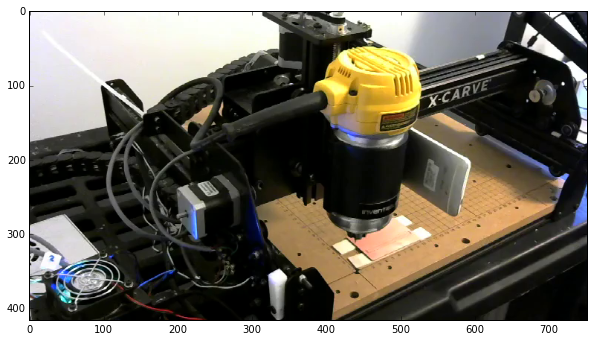

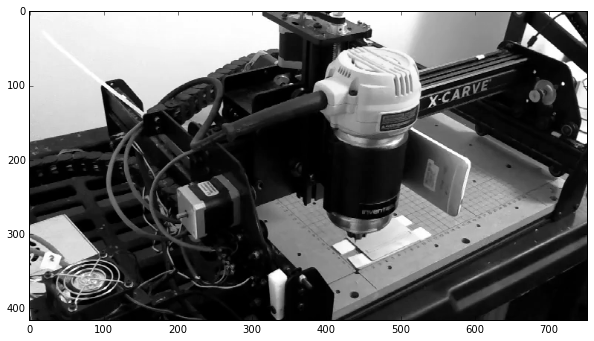

In [19]:
vimg, vimg_g = get_img(vimgs[0])
plt.imshow(vimg)
plt.show()
plt.imshow(vimg_g, cmap=plt.get_cmap('gray'))

In [20]:
sift = cv2.SIFT()

kp = sift.detect(vimg_g,None)

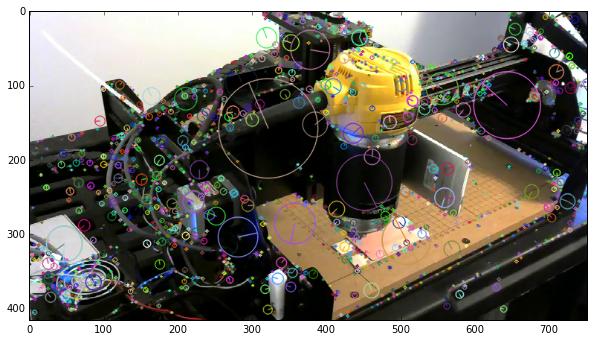

In [21]:
plt.imshow(cv2.drawKeypoints(vimg,kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

Above, we can see all of our SIFT key points, these are good, but we want to know how to CNC changes from one frame to the next. To do this, we use multipleframes where motion occurs. But that is for later :)

[Take a look at this tutorial](http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html)

We're going to begin by manually finding the X-calibration frames, then using them to find features that are moving. These moving features should correspond to the router's x position as they move.

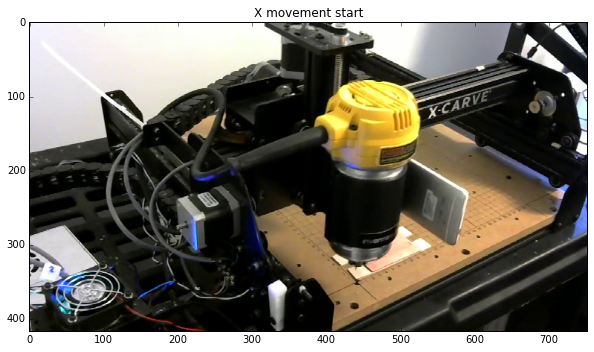

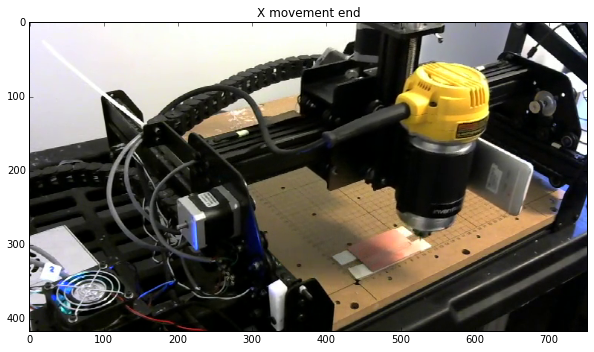

In [22]:
xcal = (149, 225)
(img1,img1_g), (img2, img2_g) = get_img(vimgs[xcal[0]]), get_img(vimgs[xcal[1]])
plt.title("X movement start")
plt.imshow(img1)
plt.show()
plt.title("X movement end")
plt.imshow(img2)
plt.show()

In [23]:
import numpy as np

In [24]:
def dosift(img1, img2,sensitivity=.5):
    sift = cv2.SIFT()
 
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    matchesMask = [[0,0] for i in xrange(len(matches))]
    
    pts1 = []
    pts2 = []
    
    for i,(m,n) in enumerate(matches):
        if m.distance < sensitivity*n.distance:
            pts2.append(np.asarray(kp2[m.trainIdx].pt))
            pts1.append(np.asarray(kp1[m.queryIdx].pt))
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    return pts1, pts2

In [25]:
pts1, pts2 = dosift(img1, img2)

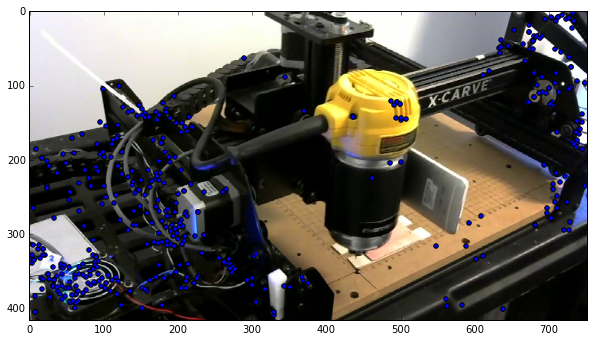

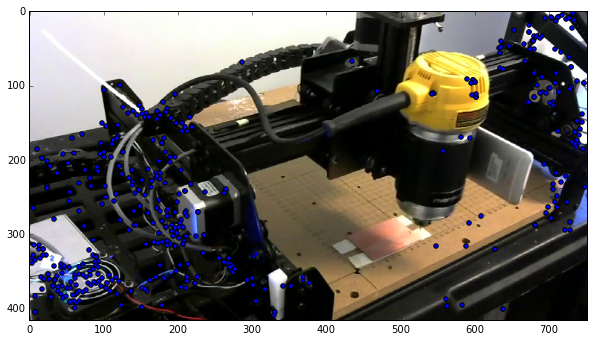

In [26]:
plt.scatter(pts1[:,0], pts1[:,1])
plt.imshow(img1)
plt.show()
plt.scatter(pts2[:,0], pts2[:,1])
plt.imshow(img2)

In [27]:
# remove points that haven't moved significantly
moved = np.ones(len(pts1)).astype(int)
for i,p1,p2 in zip(range(len(pts1)), pts1, pts2):
    if np.sum(np.abs(p1 - p2)) < 50:
        moved[i] = 0

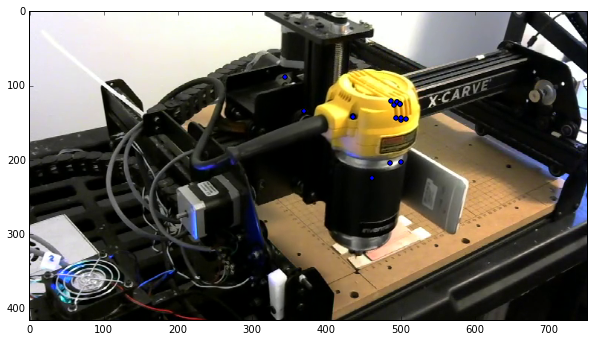

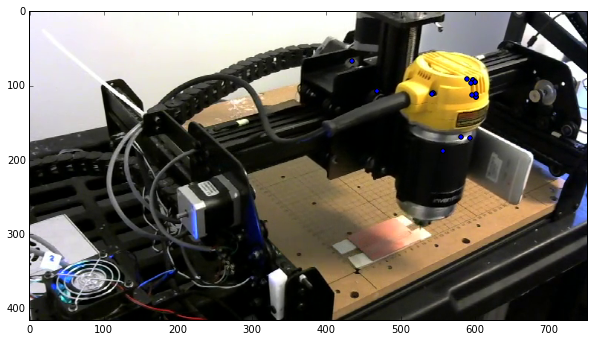

In [28]:
plt.scatter(pts1[moved==1][:,0], pts1[moved==1][:,1])
plt.imshow(img1)
plt.show()
plt.scatter(pts2[moved==1][:,0], pts2[moved==1][:,1])
plt.imshow(img2)

In [29]:
# Let's make those points a new array
p1s, p2s = pts1[moved==1], pts2[moved==1]

In [30]:
# TODO remove noise using simple clustering/variable threshold

In [31]:
# The average point is essentially the x coordinate
avg1 = np.sum(p1s,axis=0)/p1s.shape[0]
avg2 = np.sum(p2s,axis=0)/p2s.shape[0]
avg1,avg2

(array([ 465.19634501,  143.80748028]), array([ 565.07963732,  113.55677838]))

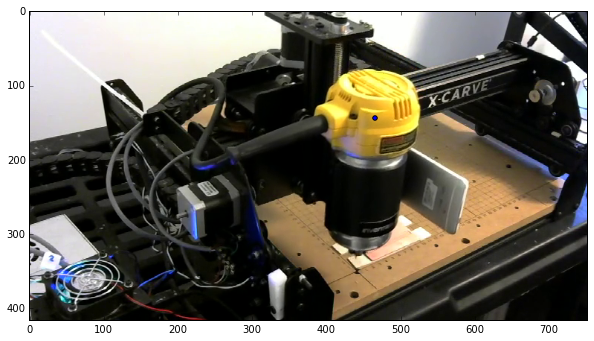

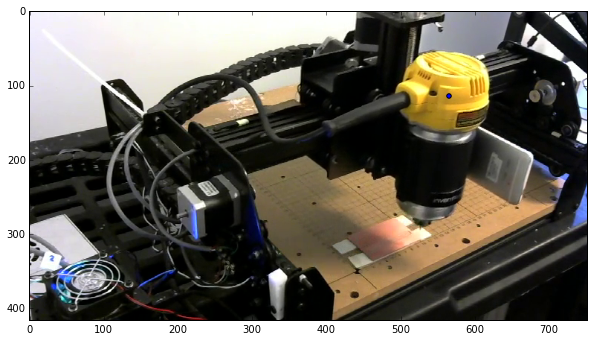

In [32]:
plt.scatter(avg1[0], avg1[1])
plt.imshow(img1)
plt.show()
plt.scatter(avg2[0], avg2[1])
plt.imshow(img2)

So using those moving features to detect the center of the router worked really well, now let's isolate the descriptions of those features so we can identify them in every frame of the video.

In [33]:
# img1 = X/Y/Z calibration start
# img2 = X/Y/Z calibration end
def getDescriptors(img1, img2, sensitivity=.5):
    sift = cv2.SIFT()

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    pts1 = []
    pts2 = []
    desi = []

    for i,(m,n) in enumerate(matches):
        if m.distance < sensitivity*n.distance:
            pts2.append(np.asarray(kp2[m.trainIdx].pt))
            pts1.append(np.asarray(kp1[m.queryIdx].pt))
            desi.append(i)

    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    desi = np.array(desi)

    # Create a mask that ignores points that haven't moved significantly
    moved = np.ones(len(pts1)).astype(int)
    for i,p1,p2 in zip(range(len(pts1)), pts1, pts2):
        if np.sum(np.abs(p1 - p2)) < 50:
            moved[i] = 0

    des_final = np.array([des1[i] for i in desi[moved==1]])
    return des_final

In [34]:
des = getDescriptors(img1, img2, sensitivity=.6)

Let's use this descriptor against a random frame and see how well it can identify the router

In [35]:
def findRouter(img, train_des,sensitivity=.5):
    sift = cv2.SIFT()
 
    test_kp, test_des = sift.detectAndCompute(img,None)
#     return np.array([kp.pt for kp in test_kp])
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(train_des, test_des,k=2)
#     return np.array([test_kp[m.trainIdx].pt for i,(m,n) in enumerate(matches)])
    
    pts1 = []
    
    for i,(m,n) in enumerate(matches):
        if m.distance < sensitivity*n.distance:
            pts1.append(np.asarray(test_kp[m.trainIdx].pt))
    pts1 = np.array(pts1)
    # Find average of points
    return np.sum(pts1, axis=0) / pts1.shape[0]
#     return np.sum(pts1, axis=1)

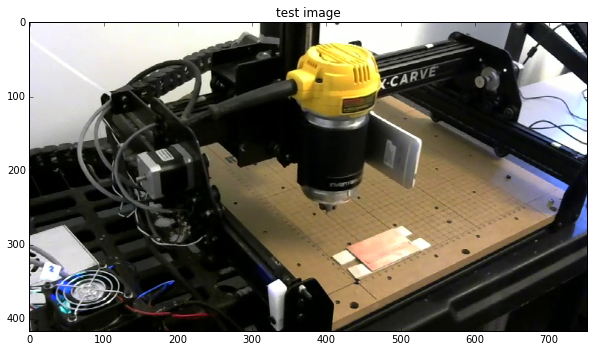

In [36]:
test_img, test_img_g = get_img(vimgs[2663])
# test_img, test_img_g = get_img(vimgs[300])
plt.title("test image")
plt.imshow(test_img)

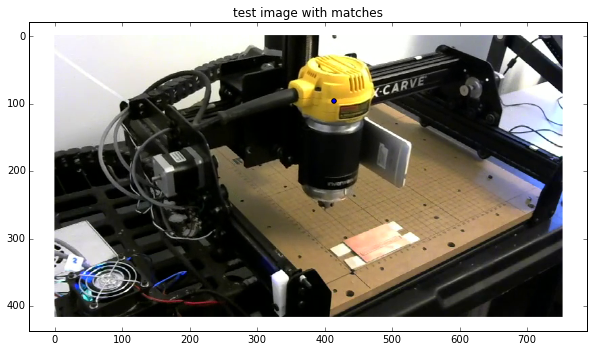

In [37]:
matches = findRouter(test_img, des, sensitivity=.7)
plt.title("test image with matches")
plt.imshow(test_img)
plt.scatter(matches[0], matches[1])

We can now try performing this matching operation on a series of frames in the video, logging the X and Y coordinates

In [38]:
from tqdm import *

*Note: I use tqdm, which is a progress bar for ipython notebooks- everything here works if you remove the wrapping "tqdm(...)" function*

In [27]:
recorded_positions = []
for i in tqdm(range(0,len(vimgs))):
    test_img, test_img_g = get_img(vimgs[i])
    router_position = findRouter(test_img, des, sensitivity=.7)
    recorded_positions.append(router_position)
recorded_positions = np.array(recorded_positions)

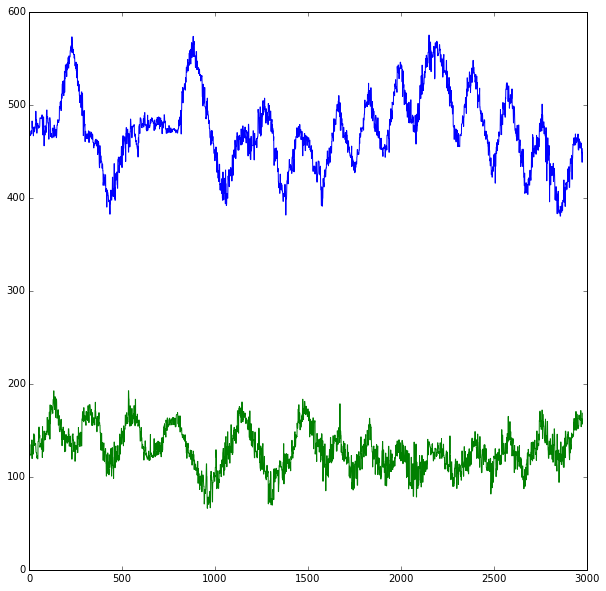

In [28]:
plt.plot(recorded_positions[:,0])
plt.plot(recorded_positions[:,1])

In [33]:
np.save("./recorded_positions.npy", recorded_positions)

# Checkpoint!

Start from here if you already have the recorded positions

In [73]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np
from os import path
from tqdm import tqdm

In [31]:
%matplotlib inline

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [33]:
xcal = (149, 225)
ycal = (370, 440)

In [34]:
recorded_positions = np.load("./recorded_positions.npy")

## Projection

Let's project a vector we derive from the average vector 

(471.81893764398035, 561.81153971354172)


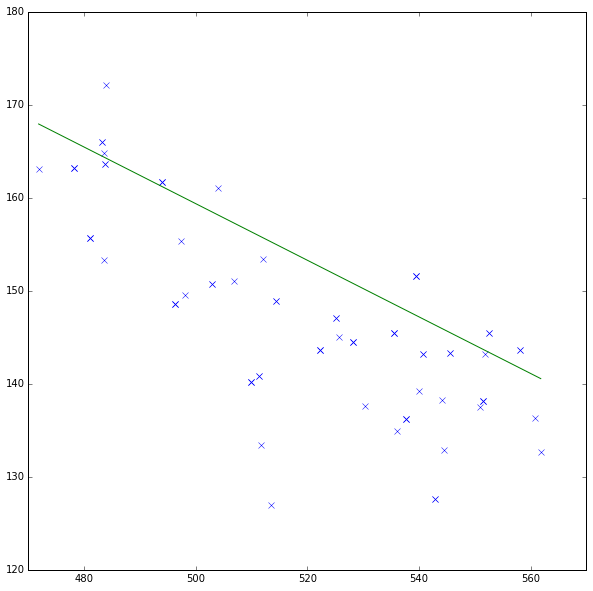

In [35]:
xcal_poly = np.polyfit(recorded_positions[:,0][xcal[0]:xcal[1]],recorded_positions[:,1][xcal[0]:xcal[1]],2)
plt.plot(recorded_positions[:,0][xcal[0]:xcal[1]], recorded_positions[:,1][xcal[0]:xcal[1]],'x')
linefunc = np.poly1d(xcal_poly)
xspan = (np.min(recorded_positions[xcal[0]:xcal[1]][:,0]), np.max(recorded_positions[xcal[0]:xcal[1]][:,0]))
print(xspan)
plt.plot(xspan, linefunc(xspan))
# xcal_vec = xcal_vec / np.linalg.norm(xcal_vec)

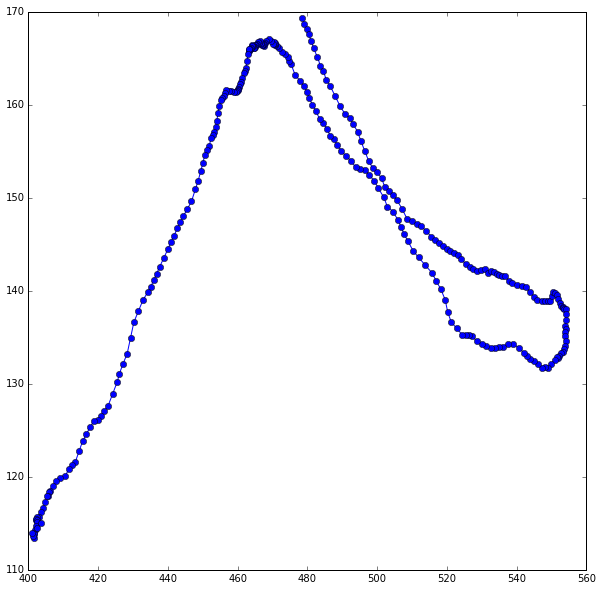

In [36]:
# let's graph a bit to get a feel for the data
def smooth(ar,amount):
    nar = []
    for i in range(len(ar)):
        nar.append(np.mean(ar[max(0,i-amount):min(i+amount,len(ar))],axis=0))
    return np.array(nar)
rp = smooth(recorded_positions, 20)
plt.plot(rp[:,0][xcal[0]:ycal[1]], rp[:,1][xcal[0]:ycal[1]],'o-')
# inc = 500
# for i in range(0,3000 - inc,inc):
#     plt.title("{} through {}".format(i, i + inc))
#     plt.plot(rp[:,0][i:i+inc], rp[:,1][i:i+inc],'o-')
#     plt.show()

The below code illustrates a homogeneous transform using w=1 to represent the projected matrix and w=2 to represent the unprojected matrix. The solution can be used to find the top of the rectangle, or the center.

In [37]:
# Let's do a homogeneous projection
projected = np.array([
        [1, 1, 1], #p1
        [2, 2, 1], #p2
        [0, 2, 1]  #p3
    ])
unprojected = np.array([
        [0, 0, 2], #bl
        [10,0, 2], #br
        [0 ,10,2]  #tl
    ])

projected_top = np.array([1, 3, 1])
projected_center = np.array([1,2,1])

sol = np.linalg.solve(projected, unprojected)
print("Top", np.dot(projected_top, sol))
print("Center", np.dot(projected_center, sol))

('Top', array([ 10.,  10.,   2.]))
('Center', array([ 5.,  5.,  2.]))


Let's create a simple box using our calibration data

In [38]:
prj1 = rp[xcal[0]] # this is theoretically the same as ycal[0]
prj2 = rp[xcal[1]]
prj3 = rp[ycal[1]]

prj_mat = np.c_[np.vstack([prj1, prj2, prj3]), np.ones(3)]
unprojected = np.array([
        [0, 0, 2], #bl
        [1, 0, 2], #br
        [0, 1,2]   #tl
    ])

sol = np.linalg.solve(prj_mat, unprojected)
rsol = np.linalg.solve(unprojected, prj_mat)
# Let's solve for the top
print(prj_mat)
np.dot([1,1,2], rsol)

[[ 478.5735597   169.37972112    1.        ]
 [ 553.69989969  138.00563521    1.        ]
 [ 403.27093006  114.96931794    1.        ]]


array([ 478.39727005,   83.59523203,    1.        ])

Sweet! We have the transformation matrix! Let's find all the points.

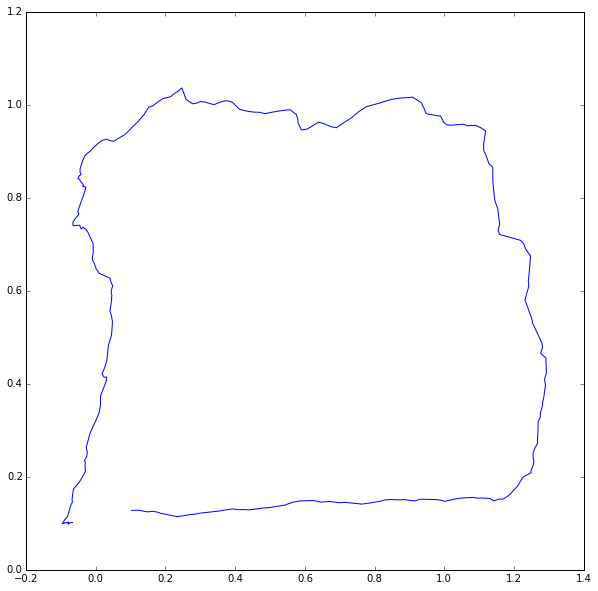

In [39]:
coords = np.dot(np.c_[rp,np.ones(len(rp))],sol)
rng = 800, 1150
plt.plot(coords[:,0][rng[0]:rng[1]], coords[:,1][rng[0]:rng[1]])

In [40]:
minx, maxx = np.min(coords[:,0]), np.max(coords[:,0])
miny, maxy = np.min(coords[:,1]), np.max(coords[:,1])
coords[:, 0] = ((coords[:, 0] - minx) / (maxx - minx)) * 4
coords[:, 1] = ((coords[:, 1] - miny) / (maxy - miny)) * 4

In [41]:
totalImages = 2975
totalVideoTime = 3 * 60 + 12
secondsPerFrame = totalImages / float(totalVideoTime)

In [42]:
time = np.linspace(0, totalVideoTime, totalImages)

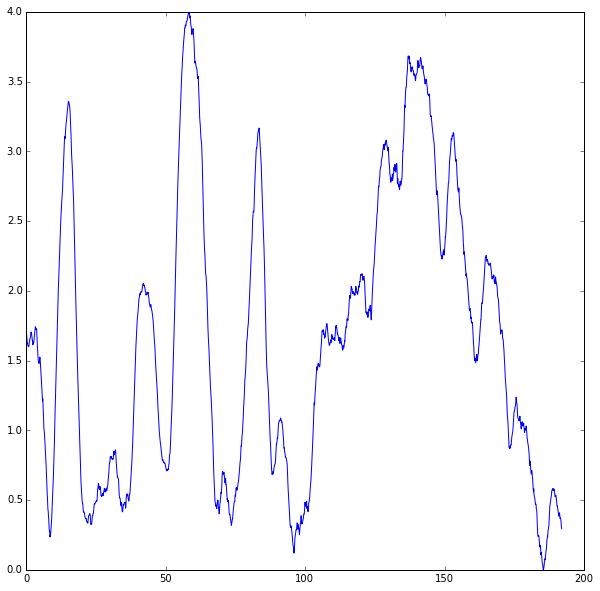

In [43]:
plt.plot(time, coords[:,0])

In [44]:
import imp
gcode_parser = imp.load_source('gcode_parser', '../gcode_parser/python/gcode_parser.py')

In [45]:
gcodex, gcodey, gcodetime = gcode_parser.parse("../gcode_parser/sample.gcode")

In [46]:
gcodex,gcodey,gcodetime = np.array(gcodex), np.array(gcodey), np.array(gcodetime)

In [47]:
#correct for time error from gcode parser
mint = np.min(gcodetime)
maxt = np.max(gcodetime)
gcodetime = (gcodetime - mint) / (maxt - mint) * totalVideoTime

In [48]:
gcodetime

array([   0.        ,    5.70695873,   11.41391746,   15.21855661,
         20.92551535,   26.63247408,   30.43711323,   31.86385291,
         33.29059259,   37.09523175,   42.80219048,   48.50914921,
         54.21610794,   59.92306667,   63.72770582,   71.79856426,
         77.50552299,   83.21248172,   87.01712087,   92.76849241,
         98.51986394,  104.27123547,  110.022607  ,  115.77397853,
        121.52535006,  127.27672159,  133.02809312,  136.83273227,
        137.54610211,  143.25306084,  143.96643069,  149.67338942,
        150.38675926,  156.09371799,  156.80708783,  162.51404656,
        163.2274164 ,  168.93437513,  169.64774497,  175.3547037 ,
        176.06807354,  181.77503227,  182.48840212,  188.19536085,  192.        ])

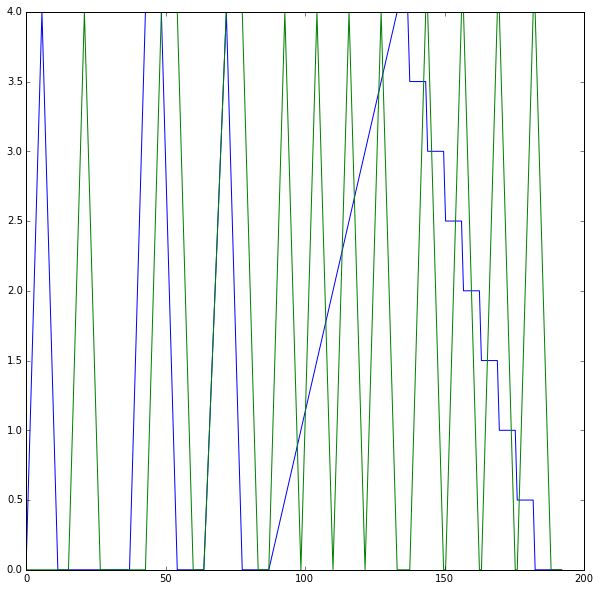

In [49]:
plt.plot(gcodetime, gcodex)
plt.plot(gcodetime, gcodey)

# Error waveforms

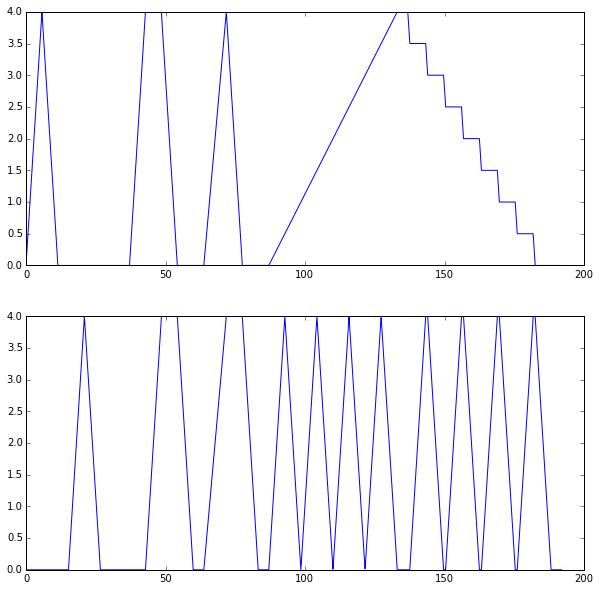

In [58]:
dgcx = np.zeros(totalImages)
dgcy = np.zeros(totalImages)
for t,ti in zip(time, range(len(time))):
    for i in range(len(gcodetime)):
        if gcodetime[i] < t <= gcodetime[i+1]:
            # interpolate between the points
            dt = gcodetime[i+1] - gcodetime[i]
            dx = gcodex[i+1] - gcodex[i]
            dy = gcodey[i+1] - gcodey[i]
            # (y - y') = m(x - x')
            # where y is the x/y, x is t
            dgcx[ti] = gcodex[i] + dx/dt * (t - gcodetime[i])
            dgcy[ti] = gcodey[i] + dy/dt * (t - gcodetime[i])
            break
plt.subplot(2,1,1)
plt.plot(time, dgcx)
plt.subplot(2,1,2)
plt.plot(time, dgcy)

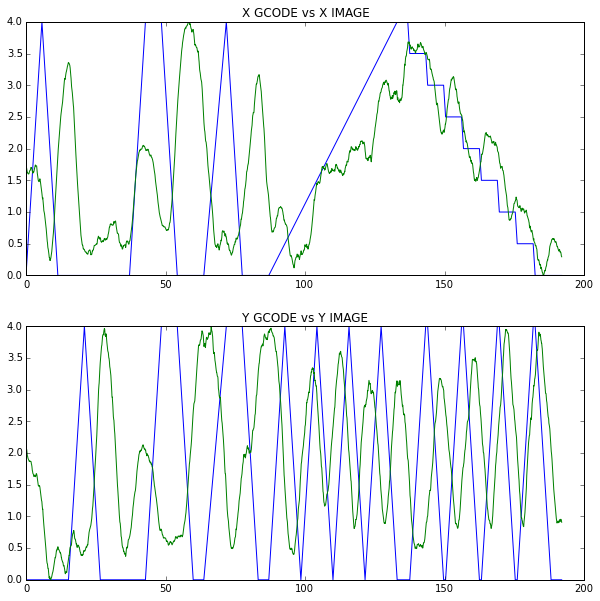

In [25]:
plt.subplot(3,1,1)
plt.title("X GCODE vs X IMAGE")
plt.plot(gcodetime, gcodex)
plt.plot(time, coords[:,0])
plt.subplot(3,1,2)
plt.title("Y GCODE vs Y IMAGE")
plt.plot(gcodetime, gcodey)
plt.plot(time, coords[:,1])
plt.subplot(3,1,3)
plt.title("ERROR X + Y")
plt.plot(gcodetime, gcodey -  )
plt.plot(time, coords[:,1])


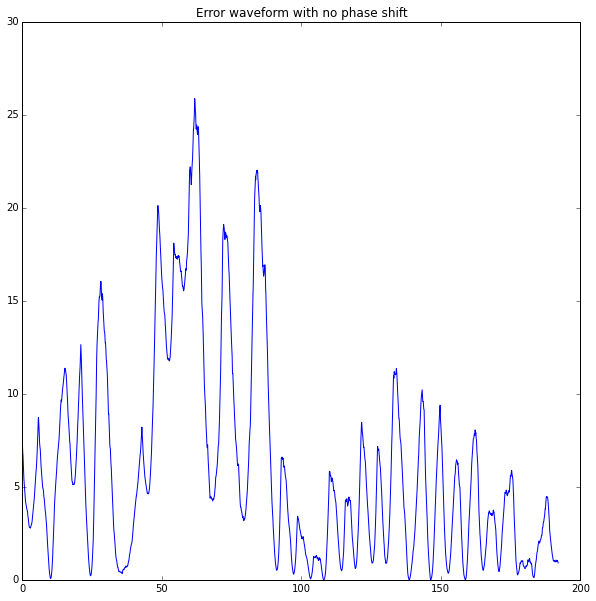

In [60]:
# dgcx, dgcy
plt.title("Error waveform with no phase shift")
plt.plot(time, (coords[:,0] - dgcx)**2 + (coords[:,1] - dgcy)**2)

In [70]:
def shift(t, wave):
    t = t % len(wave)
    end = wave[-t:]
    begin = wave[:-t]
    return np.r_[end, begin]

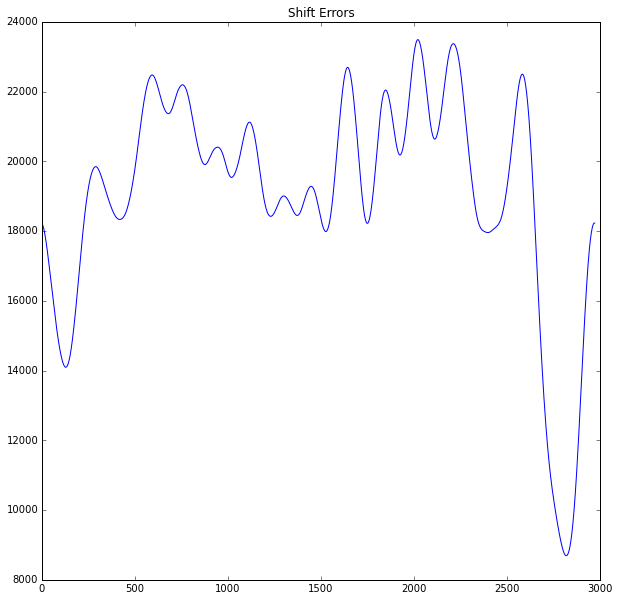

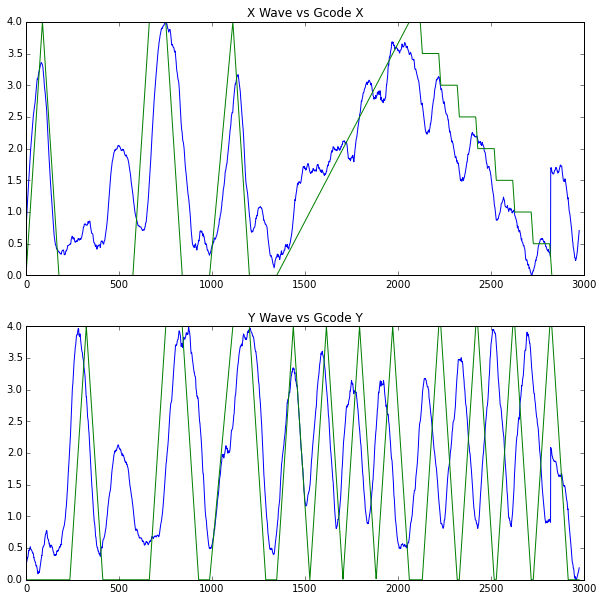

In [81]:
# Let's look at the sum of the error over time
# dgcx, dgcy
iwavex,iwavey = coords[:,0], coords[:,1]
# Compare every shift of the waveform to the gcode
shift_errors = []
for i in range(len(time)):
    shifted_iwavex = shift(i, iwavex)
    shifted_iwavey = shift(i, iwavey)
    shift_errors.append(np.sum(np.abs(shifted_iwavex - dgcx)**2 + np.abs(shifted_iwavey - dgcy)**2))
plt.title("Shift Errors")
plt.plot(shift_errors)
plt.show()
plt.subplot(2,1,1)
best_shift = np.argmin(shift_errors)
plt.title("X Wave vs Gcode X")
plt.plot(shift(best_shift, iwavex))
plt.plot(dgcx)
plt.subplot(2,1,2)
plt.title("Y Wave vs Gcode Y")
plt.plot(shift(best_shift, iwavey))
plt.plot(dgcy)

# Scaling issues!